## MIR Assignment: Feature extraction and classification
## - Abhishek Choubey 

Type classification and visualization task using Essentia Music Extractor.

In [ ]:
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install mirdata
!pip install pandas

!pip install seaborn
!pip install sklearn
!pip install umap-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 52.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=26ac3f617fff11356088ab1d1c527c7012e289b922f4e64de38441a64e65f3e0
  Stored in directory: /root/.cache/

In [ ]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support MIR
import mirdata
import essentia.standard as ess
import pandas as pd


## Data processing

Initialize Freesound One-Shot Percussive Sounds a collection of 10254 audio examples of different drum one shots. 

In this experiment we predict 6 drum classes. 

In [ ]:
# Mount the drive to access the dataset from it.

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Initialize th freesound dataset

freesound_1shot_dataset = mirdata.initialize("freesound_one_shot_percussive_sounds", data_home="/content/drive/MyDrive/mir_dataset")

In [ ]:
freesound_1shot_dataset_ids = freesound_1shot_dataset.track_ids  # Load Freesound IDs
freesound_1shot_dataset_data = freesound_1shot_dataset.load_tracks()  # Load Freesound data

# Since the above operation gives a dictionary, I want to retreive the required info from the dictionary and save it in a list

from itertools import islice

def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

dict_len= len(freesound_1shot_dataset_data.items())
print(dict_len)

n_items = take(dict_len, freesound_1shot_dataset_data.items())

needed_info = []
for i in range(0, len(n_items)):
  needed_info.append(n_items[i][1])


10254


### Dataset filtering

Each file in the freesound dataset has a class component attached to it called track and in that class component there is tag object. However the tag object has multiple tags defined for each file. So each file has multiple tags such as, drum, one-shot, kick, electronic etc. I filtered out the tags and only take those files which have the required_tags mentioned in there tags

In [ ]:
# filtering out only necessary elements from the class component
# also filtering out tracks that have required_tags in their tags



required_tags = ["kick", "snare", "cymbal", "tom", "hi-hat", "percussion"]
audio_paths = []
track_ids = []
tags = []
for track in needed_info:
    if any(tag in track.tags for tag in required_tags):
        audio_paths.append(track.audio_path)
        track_ids.append(track.track_id)
        tags.append(track.tags)

combined_list = list(zip(track_ids, audio_paths, tags))

#printing the combined list with only first five element of the list to visualize
print(combined_list[:5])

#calculating the count and printing the count of each tag
kick_count = [tup[2].count('kick') for tup in combined_list].count(1)
snare_count = [tup[2].count('snare') for tup in combined_list].count(1)
cymbal_count = [tup[2].count('cymbal') for tup in combined_list].count(1)
tom_count = [tup[2].count('tom') for tup in combined_list].count(1)
hi_hat_count = [tup[2].count('hi-hat') for tup in combined_list].count(1)
percussion_count = [tup[2].count('percussion') for tup in combined_list].count(1)


print(kick_count, snare_count, cymbal_count, tom_count, hi_hat_count, percussion_count)




[('16321', '/content/drive/MyDrive/mir_dataset/one_shot_percussive_sounds/1/16321.wav', ['16inch', 'drum', 'tom']), ('3109', '/content/drive/MyDrive/mir_dataset/one_shot_percussive_sounds/1/3109.wav', ['drum', 'kit', 'tom']), ('90144', '/content/drive/MyDrive/mir_dataset/one_shot_percussive_sounds/1/90144.wav', ['snare']), ('83138', '/content/drive/MyDrive/mir_dataset/one_shot_percussive_sounds/1/83138.wav', ['bd', 'drum', 'goa', 'goakick', 'kick', 'psy', 'psykick']), ('88723', '/content/drive/MyDrive/mir_dataset/one_shot_percussive_sounds/1/88723.wav', ['bass', 'drum', 'kick', 'snare'])]
1275 4496 476 524 465 1762


In [ ]:
#filtering out the data needed from the list


filtered_list = [tup for tup in combined_list if any(tag in tup[2] for tag in required_tags)]

new_filtered_list = []

#since the lowest count of a tag is around 450, we normalize the number of the sound considered in this experiment to 450
#and then make a new list with only those sounds (a list of 450*6 sounds)

for tag in required_tags:
    tag_tuples = [tup for tup in filtered_list if tag in tup[2]]
    if len(tag_tuples) > 450:
        tag_tuples = tag_tuples[:450]
    new_filtered_list += tag_tuples

new_combined_list = [(tup[1], tup[0], tup[2]) for tup in new_filtered_list]


print(len(new_combined_list))




2700


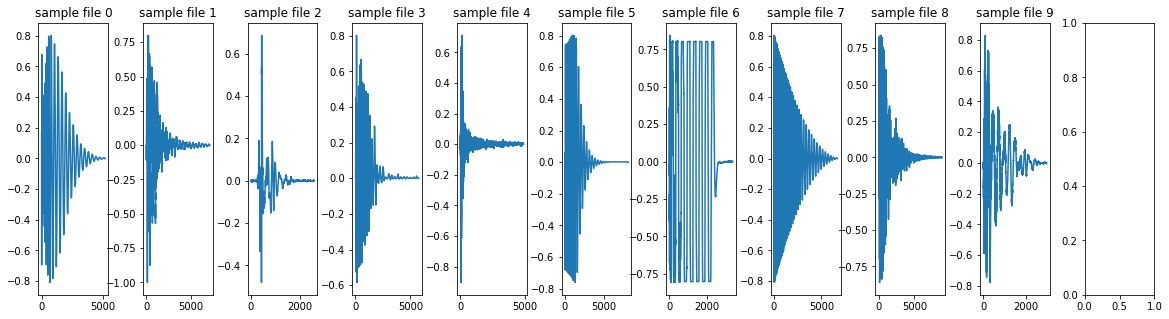

In [ ]:
# Raw-data preprocess analysis parameters
_, fs = freesound_1shot_dataset_data[freesound_1shot_dataset_ids[0]].audio


fig, axs = plt.subplots(1, len(new_combined_list[:11]), figsize=(20, 5))

for i in range(0, len(new_combined_list[:10])):
  sample_file = new_combined_list[i][0]
  x = ess.MonoLoader(filename=sample_file, sampleRate=fs)()
  axs[i].plot(x)
  axs[i].set_title(f"sample file {i}")
  
plt.subplots_adjust(wspace=0.5)
plt.show()





## Preprocessing of raw data: Segmentation, splitting, alignment,... 



In the downloaded dataset, recordings includes notes of different drum one shots, as the mrindangam dataset some of the shots here also have a silence region at the start of the note. We would like to investigate the option of splitting using a fixed energy threshold (which would help us seperate notes using the silence regions).

In [ ]:
# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.005 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [ ]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

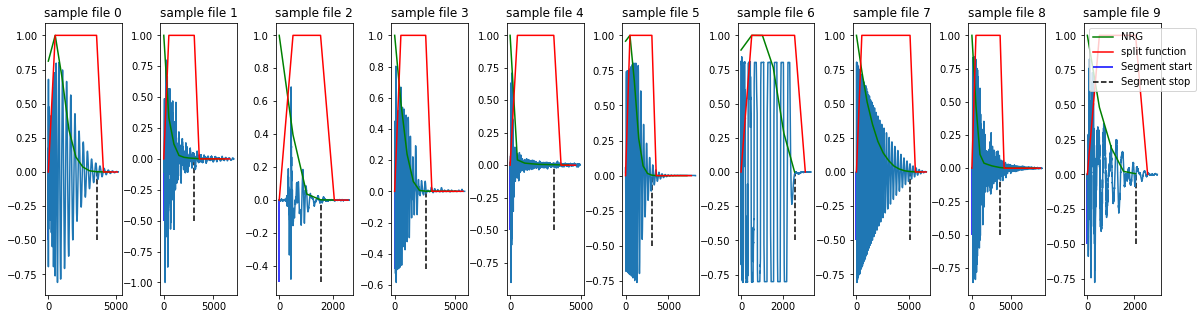

In [ ]:



##########

fig, axs = plt.subplots(1, 10, figsize=(20, 5))

for i in range(len(new_combined_list)):
    if i < 10:
        sample_file = new_combined_list[i][0]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        axs[i].plot(x)
        axs[i].plot(np.arange(NRG.size) * hopSize, NRG, 'g', label='NRG')
        axs[i].plot(np.arange(split_decision_func.size) * hopSize, split_decision_func, 'r', label='split function')
        axs[i].vlines(start_indexes, ymin=-0.5, ymax=0, colors='b', linestyles='solid', label='Segment start')
        axs[i].vlines(stop_indexes, ymin=-0.5, ymax=0, colors='k', linestyles='dashed', label='Segment stop')
        axs[i].set_title(f"sample file {i}")
    else:
        break

plt.legend(loc="best")
plt.subplots_adjust(wspace=0.5)
plt.show()





In [ ]:
# we then create a new folder with the segmented files seperate from the original dataset

main_data_dir = '/content/drive/MyDrive/sample_data'
if not os.path.exists(main_data_dir): #creating the directory
    os.mkdir(main_data_dir)
segments_dir = os.path.join(main_data_dir,'segments')
if not os.path.exists(segments_dir): #creating the directory
    os.mkdir(segments_dir)

segment_files = []
for i in range(len(new_combined_list)):
      #Get file id
      sample_file = new_combined_list[i][0]
      file_id =  new_combined_list[i][1]
      x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
      (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Croping segments
      for start, stop in zip(start_indexes, stop_indexes):
          x_seg = x[start: stop]
          #Final check for amplitude (to avoid silent segments selection due to noise in split function)
          if(np.max(np.abs(x_seg)) > 0.05):
                #Amplitude normalisation
            x_seg = x_seg / np.max(np.abs(x_seg))
            filename = os.path.join(segments_dir, file_id + '.wav')
            ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
            segment_files.append(filename)

print(len(segment_files),'segment files created')

2262 segment files created


## Feature extraction 

Computing a list of common features for each of the files and form a data frame including features and categories. As suggested in the Feature Extraction notebook I used the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [ ]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(new_combined_list[1][0])

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

## Create Csv files with the feature values

first I create the csv file for my new combined list, which has only the selected filtered audio samples, this csv file has path, track id and the tags in it.


Then, the features are computed and  the data csv file with features is created. Post that, I mergee both of them the feature csv file and hte new combined list file, then I make a new file with the final 6 filtered tags

In [ ]:
import csv

with open('/content/drive/MyDrive/sample_data/new_combined_list.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Audio Path', 'track_id', 'Tags'])  # header row
    for audio_path, track_id, tags in new_combined_list:
        writer.writerow([audio_path, track_id, tags])

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [ ]:
# Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the id of the track as the last element
data_file = '/content/drive/MyDrive/sample_data/data.csv'
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['stroke']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for filename in segment_files:
        file_count +=1
        if file_count % 20 == 0: #print name of a file every 20 files
            print(file_count, "files processed, current file: ", filename)

        #Compute and write features for file
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(filename)
        selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
        label = filename.split('/')[-1].split('.')[0].split('-')[0]
        line2write = str(selected_features)[1:-1] + ',' + label + '\n'
        writer.write(line2write)
print("A total of ", file_count, "files processed")

20 files processed, current file:  /content/drive/MyDrive/sample_data/segments/58463.wav
40 files processed, current file:  /content/drive/MyDrive/sample_data/segments/58461.wav
60 files processed, current file:  /content/drive/MyDrive/sample_data/segments/7631.wav
80 files processed, current file:  /content/drive/MyDrive/sample_data/segments/85176.wav
100 files processed, current file:  /content/drive/MyDrive/sample_data/segments/13857.wav
120 files processed, current file:  /content/drive/MyDrive/sample_data/segments/35996.wav
140 files processed, current file:  /content/drive/MyDrive/sample_data/segments/36087.wav
160 files processed, current file:  /content/drive/MyDrive/sample_data/segments/72995.wav
180 files processed, current file:  /content/drive/MyDrive/sample_data/segments/38907.wav
200 files processed, current file:  /content/drive/MyDrive/sample_data/segments/26053.wav
220 files processed, current file:  /content/drive/MyDrive/sample_data/segments/41419.wav
240 files proce

## merge the csv files

In [ ]:
# Read CSV files
df1 = pd.read_csv('/content/drive/MyDrive/sample_data/new_combined_list.csv')
df2 = pd.read_csv('/content/drive/MyDrive/sample_data/data.csv')

df1.head()

# Merge dataframes based on stroke and track id columns
merged_df = pd.merge(df1, df2, left_on='track_id', right_on='stroke', how='inner')

# Save merged dataframe to a new CSV file
merged_df.to_csv('/content/drive/MyDrive/sample_data/merged_data.csv', index=False)

In [ ]:
 
#Read data with pandas module
merged_data = pd.read_csv('/content/drive/MyDrive/sample_data/merged_data.csv')

#Plot first lines of our data
merged_data.head()

,Audio Path,track_id,Tags,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,stroke
0,/content/drive/MyDrive/mir_dataset/one_shot_pe...,83138,"['bd', 'drum', 'goa', 'goakick', 'kick', 'psy'...",0.990684,20.975876,7.762748,0.673184,0.230984,91.846832,111.301491,...,466.943634,11.178209,6.178418,5240850.0,9634291.0,0.544991,0.455130,0.003862,0.003315,83138
1,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,25.569262,1.010711,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723
2,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,25.569262,1.010711,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723
3,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,25.569262,1.010711,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723
4,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,25.569262,1.010711,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723


## filter out tags and make a new column called final_tags analogous to stroke in the provided feautre extraction colab notebook

Since each tag is a list of multiple tags, I take our required tags from that list and store into a new column, so that we have a column giving us our final 6 classes

In [ ]:

# Define the list of tags to check for
required_tags = ["kick", "snare", "cymbal", "tom", "hi-hat", "percussion"]



# Create a new column called 'matching_tags' and initialize it with an empty string
merged_data['matching_tags'] = ''

# Loop through each row and check if any element in the 'required_tags' list is present in the 'tags' column
for i, row in merged_data.iterrows():
    matching_tags = [tag for tag in required_tags if tag in row['Tags']]
    if len(matching_tags) > 0:
        merged_data.at[i, 'final_tags'] = matching_tags[0]

# Save updated dataframe to a new CSV file
merged_data.to_csv('/content/drive/MyDrive/sample_data/final_merged_data.csv', index=False)


In [ ]:
#Read data with pandas module
data = pd.read_csv('/content/drive/MyDrive/sample_data/final_merged_data.csv')

#Plot first lines of our data
data.head()

,Audio Path,track_id,Tags,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,...,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,stroke,matching_tags,final_tags
0,/content/drive/MyDrive/mir_dataset/one_shot_pe...,83138,"['bd', 'drum', 'goa', 'goakick', 'kick', 'psy'...",0.990684,20.975876,7.762748,0.673184,0.230984,91.846832,111.301491,...,6.178418,5240850.0,9634291.0,0.544991,0.455130,0.003862,0.003315,83138,NaN,kick
1,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723,NaN,kick
2,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723,NaN,kick
3,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723,NaN,kick
4,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723,NaN,kick


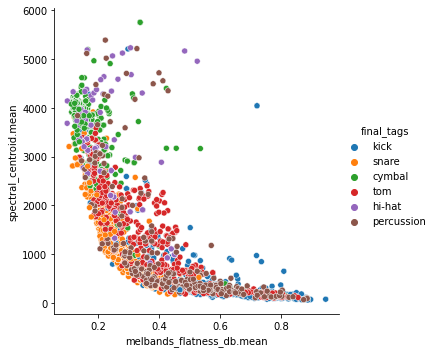

In [ ]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue ="final_tags", data = data);

### Preprocessing of the features


In [ ]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,4:84] = min_max_scaler.fit_transform(data.iloc[:,4:84].values)

In [ ]:
# Checking if our data is balanced (if not, we should balance it to prevent our model to be baised)
data_modif.final_tags.value_counts()

cymbal        927
snare         797
kick          562
tom           411
percussion    226
hi-hat        125
Name: final_tags, dtype: int64

In [ ]:
# Here we pick the hihat 123 to balance our data

min_number = data_modif.final_tags.value_counts()['hi-hat']
cymbal_data = data_modif[data_modif.final_tags == 'cymbal'].sample(n = min_number, random_state = 42)
snare_data = data_modif[data_modif.final_tags == 'snare'].sample(n = min_number)
kick_data = data_modif[data_modif.final_tags == 'kick'].sample(n = min_number)
tom_data = data_modif[data_modif.final_tags == 'tom'].sample(n = min_number)
percussion_data = data_modif[data_modif.final_tags == 'percussion'].sample(n = min_number)
hihat_data = data_modif[data_modif.final_tags == 'hi-hat'].sample(n = min_number)

#Merging after downsampling
data_modif = pd.concat([cymbal_data,snare_data, kick_data, tom_data, percussion_data, hihat_data])
#Checking the balance again
data_modif.final_tags.value_counts()

cymbal        125
snare         125
kick          125
tom           125
percussion    125
hi-hat        125
Name: final_tags, dtype: int64

## Supervised learning approach (Support Vector Machines)

In [ ]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,4:84].values 
# Creating output values
data_modif.final_tags = pd.Categorical(data_modif.final_tags)  # convert to categorical data
y = np.array(data_modif.final_tags.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [4.22959722e-01 3.39167897e-01 1.72567777e-01 9.58267701e-02
 2.18167163e-03 1.12580830e-03 3.21906746e-01 2.69327957e-02
 3.39284114e-01 4.58779544e-01 9.04617106e-01 1.04248572e-01
 0.00000000e+00 2.18780493e-01 2.96673974e-01 7.74222199e-02
 1.50710946e-01 2.84741881e-03 3.39603532e-03 4.30098688e-01
 7.60563833e-02 6.19582955e-01 2.38645175e-01 5.19738267e-02
 5.92637141e-02 4.47020729e-01 0.00000000e+00 5.03257365e-01
 0.00000000e+00 4.46787023e-01 0.00000000e+00 6.32029977e-01
 5.39328091e-01 2.34287803e-01 1.50185835e-01 2.64570092e-08
 1.84740687e-08 4.83054389e-04 6.50958118e-05 8.49006254e-02
 1.62921316e-01 4.82588365e-01 3.92792567e-01 1.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 5.95238114e-01
 1.00000000e+00 2.59793226e-01 1.41044639e-01 2.54223865e-01
 5.24065515e-01 9.95574255e-01 1.35887580e-02 4.51190742e-03
 1.37067868e-02 4.31948724e-02 5.20058530e-02 6.96204308e-03
 1.17725461e-02 1.49057990e-02 1.58854111e-02 1.583847

In [ ]:
# Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (502, 80) , Size of train output vector:  (502,)
Size of test features matrix:  (248, 80) , Size of test output vector:  (248,)


In [ ]:
# Define and train the model

from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

In [ ]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([ True, False,  True,  True, False,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True, False,  True,  True, False,  True,
        True,  True,  True, False,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.7620967741935484


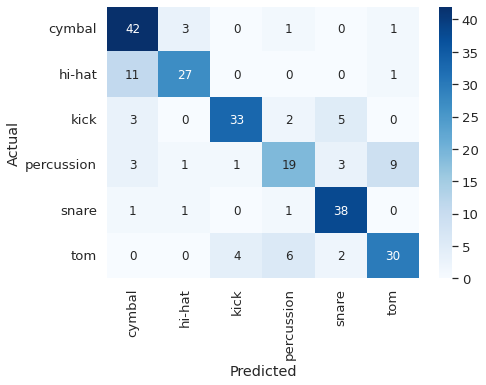

In [ ]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.final_tags)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

## Supervised learning approach (Neural Network)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# ..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (600, 6)
One-hot encoded y_test shape =  (150, 6)


In [ ]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 6))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_val.shape[1])

In [ ]:
model.summary()  # Plot summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormalizat  (None, 80)               320       
 ion)                                                            
                                                                 
 HiddenLayer_1 (Dense)       (None, 40)                3240      
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40)                0         
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 20)                8

In [ ]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0)

In [ ]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16166405379772186
Test accuracy: 0.8199999928474426


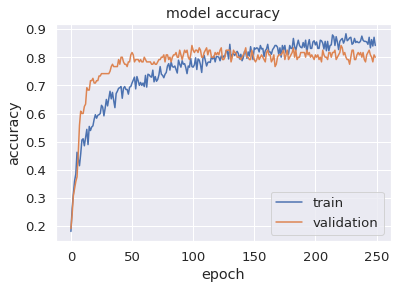

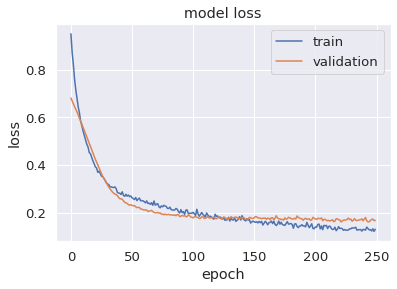

In [ ]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Sound Classification part 2

In [ ]:
# We'll need numpy and pandas for basic data wrangling
import numpy as np
import pandas as pd

# We'll need matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# We'll use some preprocessing from scikit-learn:
#  Standard scaling (z-scoring) and label encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Our classifier will be 1-nearest-neighbor after learning the distance metric
from sklearn.neighbors import KNeighborsClassifier

# Pipelines make it a little easier to manage sequences of models,
# eg scaler -> metric learner -> 1nn
from sklearn.pipeline import make_pipeline

# We'll use some standard machinery for reporting accuracy of our models
from sklearn.metrics import classification_report,  plot_confusion_matrix

from sklearn.model_selection import train_test_split


RNG_STATE = 0

from google.colab import files


In [ ]:
#Plot first lines of our data
data.head()

,Audio Path,track_id,Tags,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,...,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,stroke,matching_tags,final_tags
0,/content/drive/MyDrive/mir_dataset/one_shot_pe...,83138,"['bd', 'drum', 'goa', 'goakick', 'kick', 'psy'...",0.990684,20.975876,7.762748,0.673184,0.230984,91.846832,111.301491,...,6.178418,5240850.0,9634291.0,0.544991,0.455130,0.003862,0.003315,83138,NaN,kick
1,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723,NaN,kick
2,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723,NaN,kick
3,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723,NaN,kick
4,/content/drive/MyDrive/mir_dataset/one_shot_pe...,88723,"['bass', 'drum', 'kick', 'snare']",0.990684,13.894983,2.530404,0.280312,0.048589,25.415892,13.150990,...,0.771519,6261799.0,5952782.0,0.370364,0.539105,0.015820,0.007117,88723,NaN,kick


In [ ]:
X_train, X_test, y_train_text, y_test_text = train_test_split(data[data.columns[3:84]],data[data.columns[-1]], test_size=0.2, random_state=RNG_STATE)

In [ ]:
# We'll need to use a label encoder to encode our instrument
# names as numeric identifiers (0, 1, 2, ..., 9)
encoder = LabelEncoder()

# "Fit" on the training labels; this is really just specifying our vocabulary
# transform maps the encoding over the list of strings to give our encoded label array
y_train = encoder.fit_transform(y_train_text)

# Since the encoder is already fit, we can now transform our test set labels as well
y_test = encoder.transform(y_test_text)

              precision    recall  f1-score   support

      cymbal       0.93      0.98      0.95       161
      hi-hat       0.77      0.74      0.76        23
        kick       0.88      0.85      0.87       117
  percussion       0.80      0.71      0.75        51
       snare       0.96      0.93      0.94       175
         tom       0.76      0.84      0.80        83

    accuracy                           0.89       610
   macro avg       0.85      0.84      0.84       610
weighted avg       0.89      0.89      0.89       610



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


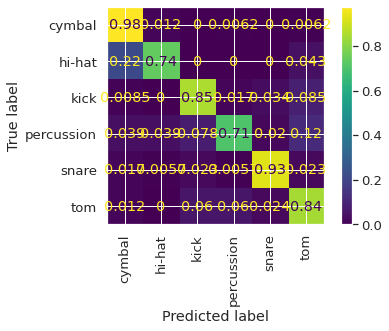

In [ ]:
# Our classifier is a "pipeline": scaling followed by KNN
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

# Fit all stages of the pipeline to our training data
clf.fit(X_train, y=y_train)

# How well does our 1-Nearest neighbor model work?
y_pred = clf.predict(X_test)

# Compare our predictions to the true labels in y_test
report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

# Finally, plot a confusion matrix showing how mistakes are distributed
plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

In [ ]:
### importing and installing libraries if there are any missing ones
!pip install seaborn
!pip install sklearn
!pip install umap-learn


### How to visualize features using metric learning https://github.com/bmcfee/ismir2020-metric-learning
# scikit-learn provides Linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Finally, umap will let us map high-dimensional data down to 2-d for plotting
import umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll apply all but the last stage (KNN classifier) of our pipeline to the data.
# In this case, we just have one previous stage, which does feature normalization.
# This will change in subsequent examples.

X_train_transformed = clf[:-1].transform(X_train)
X_test_transformed = clf[:-1].transform(X_test)

# Fit on the transformed data, and then transform the test data
embed = reducer.fit_transform(X_train_transformed)
embed_test = reducer.transform(X_test_transformed)

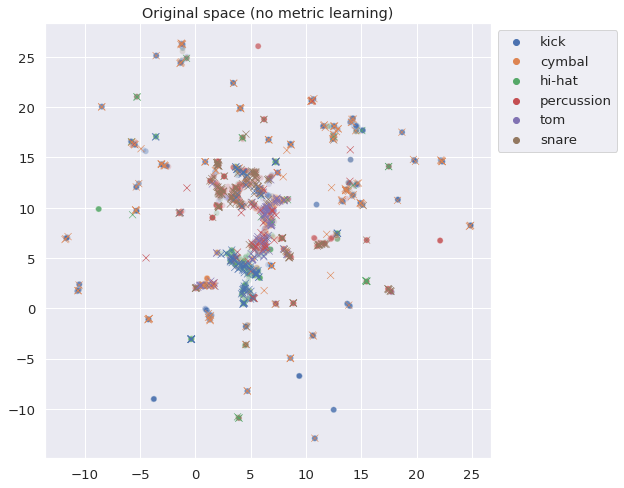

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Original space (no metric learning)');

## Linear projection of features

We use Linear Discriminant Analysis to better separate the classes by learning a 9-dimensional projection of the features.

[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing lineardiscriminantanalysis, total=   0.1s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
              precision    recall  f1-score   support

      cymbal       0.93      0.96      0.94       161
      hi-hat       0.68      0.65      0.67        23
        kick       0.85      0.85      0.85       117
  percussion       0.66      0.53      0.59        51
       snare       0.94      0.89      0.91       175
         tom       0.70      0.83      0.76        83

    accuracy                           0.85       610
   macro avg       0.79      0.78      0.79       610
weighted avg       0.85      0.85      0.85       610



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


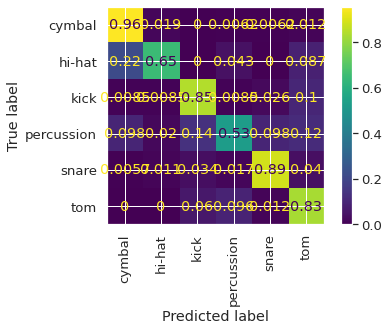

In [ ]:

clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(), KNeighborsClassifier(n_neighbors=1), verbose=True)
clf.fit(X_train, y=y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

### Visualizing the result

In [ ]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll fit the umap embedding on the data after applying our learned transformation
embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

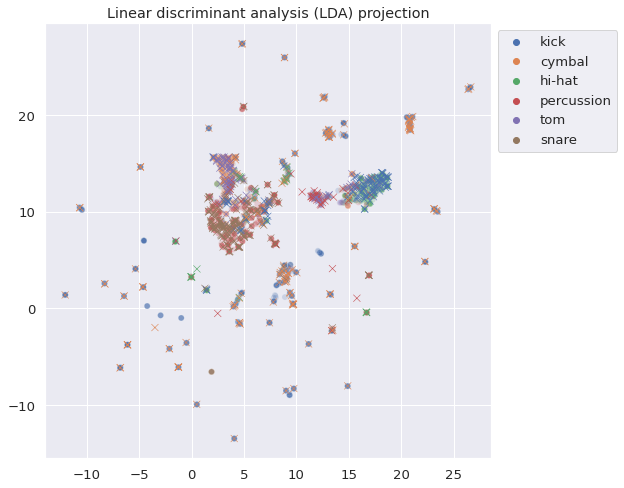

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Linear discriminant analysis (LDA) projection');

The projection learned by LDA tells us the weight assigned to each of the training features. 

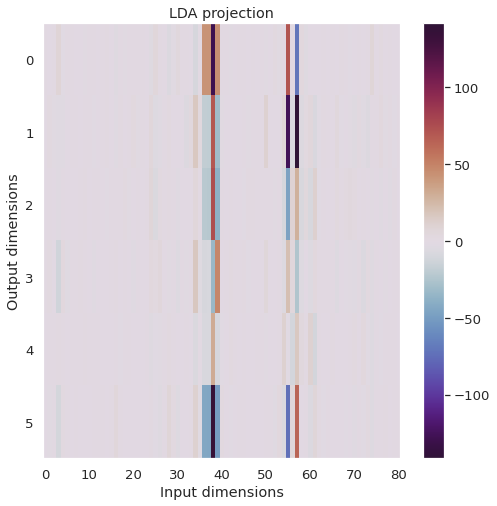

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[1][1]
weights = model.coef_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax)
ax.grid(False)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='LDA projection');

## Explantion 

For this experiment I chose the freesound one shot dataset, to do a classic classification of drum samples. The dataset was downloaded by Mirdata library. After initializing the dataset using the same library I first took the dictionary provided by the mirdata library with all the information about the datset and converted it to a list, for easy operation and iterations. I then filtered out the list with the elements that were required for this task. So the filtered list had only audio path, track id and tags. 

The tags I acquired from this operation had a list of tags attached to each track, meaning each track had multiple tags attached to them, and storred in an array for ex "track_id: 80819, tags: kick, electronic, drum, ambient etc" so I filtered this list again with only those tracks that had tags: "kick", "snare", "cymbal", "tom", "hi-hat", "percussion", in the list of tags.

After this multiple filterization of the dataset. Now I had the files which had tags as we wanted. 

Post this, I removed the silences in the audio files as done in the mridangam. Then I created new audio files without the segments. Then I calculated the features using the Essentia library, and saved them in the csv file.


After that I gave them to the machine learning models. The first model is Support Vector Machine, the accuracy I got was 76%. The confusion matrix specifies that cymbals were classified as hi hats the most amount of time, which sonically makes sense. Moreover, some toms got classified as percussions.

Later the supervised Neural Network model performed a bit better by giving the accuracy of 82%, with a test loss of 0.161664

The validation and training crosses around 140 epochs.

The KNeighborsClassifier improves the accuracy to 89%, with hihats and cymbol the most misplaced shots again.



